# Model Evaluation

This notebook evaluates the trained ResNet model on the test dataset and generates various performance metrics and visualizations. The evaluation includes:

1. Classification accuracy and performance metrics
2. Confusion matrix visualization
3. Specificity and sensitivity analysis
4. Clinical alert rate calculation for malignant cases
5. ROC and Precision-Recall curves


In [23]:
import os
from renishawWiRE import WDFReader
import pandas as pd
import numpy as np


from models.resnet import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import utils.data_utils as du
from config import (
       TRAIN_DATA_DIR,
       TEST_DATA_DIR,
       DATASET_DIR,
       MODELS_DIR,
       IMAGES_DIR,
       tissue_classification,
       metadata
)
try:
       # Set the style to use serif fonts
       sns.set_style("whitegrid")
       sns.set_context("paper")
       plt.rcParams['axes.grid'] = False
       params = {
              "text.usetex": True,
              "font.family": "serif",
              "font.serif": ["Times New Roman"],
              "text.latex.preamble": r"\usepackage{amsmath}"
       }
       mpl.rcParams.update(params)
except:
       pass



In [2]:
train_dir = TRAIN_DATA_DIR
test_dir = TEST_DATA_DIR


train_data = RamanDataset(train_dir)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

test_data = RamanDataset(test_dir)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

num_classes = len(train_data.class_to_idx)
model = RamanResNet(num_classes)


## Load Model Weights

This cell loads the saved model weights from the checkpoint file and runs the model in evaluation mode.

In [ ]:
model_checkpoint = "raman_resnet_weights"


# Load the best model weights
model_path = os.path.join(MODELS_DIR, 'checkpoints', model_checkpoint + '.pth')
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

# Evaluate the model on the test dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_logits = []
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_logits.extend(outputs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Test Accuracy: 0.9710


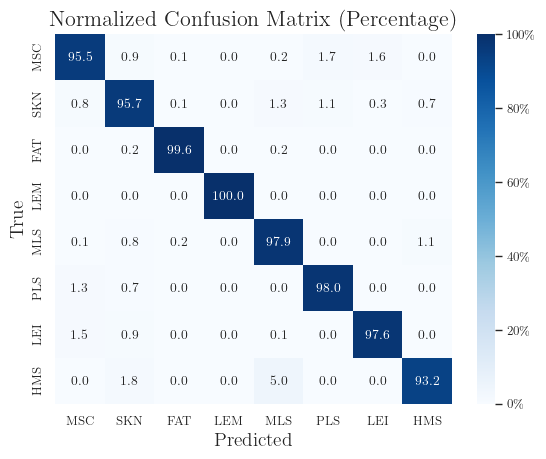

Classification Report:
              precision    recall  f1-score   support

         FAT     0.9936    0.9962    0.9949      6243
         HMS     0.9265    0.9316    0.9291      3642
         LEI     0.9600    0.9756    0.9677      3642
         LEM     1.0000    0.9995    0.9998      2081
         MLS     0.9782    0.9789    0.9785     16749
         MSC     0.9648    0.9552    0.9600      6744
         PLS     0.9556    0.9802    0.9677      5754
         SKN     0.9720    0.9574    0.9647     12487

    accuracy                         0.9710     57342
   macro avg     0.9688    0.9718    0.9703     57342
weighted avg     0.9710    0.9710    0.9710     57342



In [5]:
# Calculate accuracy and other metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
# Create a dictionary mapping tissue type abbreviations to their classifications


tissue_types = metadata['ID_Type'].unique()
tissue_types = sorted(tissue_types, key=lambda x: list(tissue_classification.keys()).index(x))


indices = [test_data.class_to_idx[class_name] for class_name in tissue_types]
indices = np.array(indices)
conf_matrix_sorted = conf_matrix[indices][:, indices]
conf_matrix_sorted_normalized = conf_matrix_sorted.astype('float') / conf_matrix_sorted.sum(axis=1)[:, np.newaxis] * 100


from matplotlib.ticker import PercentFormatter
fmt = lambda x, pos: f'{x:.0%}'
fig, ax = plt.subplots()
sns.heatmap(conf_matrix_sorted_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=tissue_types, yticklabels=tissue_types,
            cbar_kws={'format': PercentFormatter()}, vmin=0, vmax=100)

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Normalized Confusion Matrix (Percentage)', fontsize=16)
plt.show()
du.save_fig(fig=fig, 
            fig_name='confusion_matrix',
            fig_dir=IMAGES_DIR,
            fig_fmt="pdf")
# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_data.class_to_idx.keys(), digits=4))


In [6]:
specificities = []
sensitivities = []

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - TP - FP - FN

    specificity = TN / (TN + FP)
    sensitivity = TP / (TP + FN)

    specificities.append(specificity)
    sensitivities.append(sensitivity)

# Create a DataFrame to display the specificity and sensitivity for each class
metrics_df = pd.DataFrame({
    'Class': test_data.class_to_idx.keys(),
    'Specificity': specificities,
    'Sensitivity': sensitivities
})

# show results up to 3 decimal point
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(metrics_df)

  Class  Specificity  Sensitivity
0   FAT        0.999        0.996
1   HMS        0.995        0.932
2   LEI        0.997        0.976
3   LEM        1.000        1.000
4   MLS        0.991        0.979
5   MSC        0.995        0.955
6   PLS        0.995        0.980
7   SKN        0.992        0.957


## Clinical Alert Rate for Malignant Cases

This analysis focuses specifically on malignant tissue cases, calculating the Clinical Alert rate (CA). The CA rate represents the percentage of malignant cases that are incorrectly classified as benign or normal tissue types, which could lead to missed diagnoses in a clinical setting. This is a critical metric for assessing the safety of the model in medical applications.

In [7]:
malignant_cases = metadata['ID_Type'][metadata['Tissue Classification'] == 'Malignant'].unique()

# Get the indices of the malignant cases in the test dataset
malignant_indices = [test_data.class_to_idx[class_name] for class_name in malignant_cases]


CA = {}

# Calculate the false negative rate for malignant cases
total_fn = 0
total_cases = 0

for i in malignant_indices:
  TP = conf_matrix[i, i]
  FN = np.sum(conf_matrix[i, :]) - TP
  fnr = FN - np.sum(conf_matrix[i, malignant_indices]) + TP
  fnr_ratio = fnr/np.sum(conf_matrix[i, :]) * 100
  label = [label for label in test_data.class_to_idx if test_data.class_to_idx[label] == i]
  CA[label[0]] = fnr_ratio
  FP = np.sum(conf_matrix[:, i]) - TP
  TN = np.sum(conf_matrix) - (TP + FN + FP)
  
  total_fn += fnr
  total_cases += np.sum(conf_matrix[i, :])

clinical_alert_rate = total_fn / total_cases if total_cases > 0 else 0

print(f"Clinical Alert Rate for Malignant Cases: {clinical_alert_rate*100:.3f}%")
# print FNR for each class in table
FNR_df = pd.DataFrame({
    'Class': CA.keys(),
    'Clinical Alert Rate (%)': CA.values()
})
FNR_df

Clinical Alert Rate for Malignant Cases: 1.457%


,Class,Clinical Alert Rate (%)
0,PLS,1.981
1,MLS,0.997
2,HMS,1.812
3,LEI,2.389


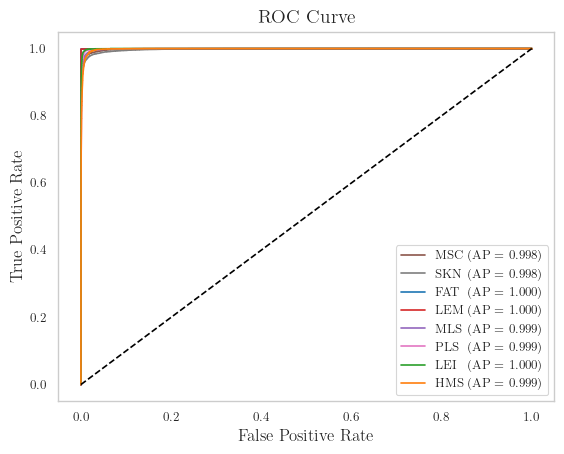

In [11]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import torch.nn.functional as F



all_logits = np.array(all_logits)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# One-hot encode the labels for multi-class ROC and PRC
num_classes = len(np.unique(all_labels))
all_labels_one_hot = np.eye(num_classes)[all_labels]
all_preds_proba = F.softmax(torch.tensor(all_logits), dim=1).numpy()


# Plot ROC curve and calculate AUC
roc_fig, roc_ax = plt.subplots()
for idx, tissue_type in enumerate(tissue_types):
    i = test_data.class_to_idx[tissue_type]
    fpr, tpr, _ = roc_curve(all_labels_one_hot[:, i], all_preds_proba[:, i])
    roc_auc = auc(fpr, tpr)
    label = rf"\makebox[0.7cm][l]{{{tissue_type}}} (AP = {roc_auc:.3f})"
    plt.plot(fpr, tpr, label=label, color=sns.color_palette("tab10")[i])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.show()
du.save_fig(fig=roc_fig, fig_name="roc_curve",
            fig_dir=IMAGES_DIR, fig_fmt="pdf")


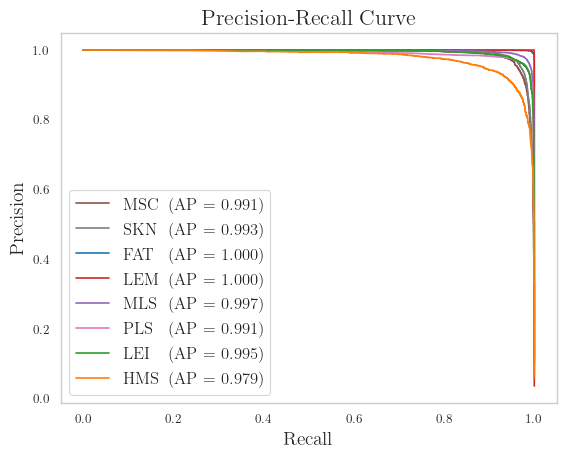

In [17]:
# Plot Precision-Recall curve
prc_fig, prc_ax = plt.subplots()
for idx, tissue_type in enumerate(tissue_types):
    i = test_data.class_to_idx[tissue_type]
    precision, recall, _ = precision_recall_curve(all_labels_one_hot[:, i], all_preds_proba[:, i])
    avg_precision = average_precision_score(all_labels_one_hot[:, i], all_preds_proba[:, i])
    # align the label to the right
    label = rf"\makebox[1cm][l]{{{tissue_type}}} (AP = {avg_precision:.3f})"
    plt.plot(recall, precision, label=label, color=sns.color_palette("tab10")[i])

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16)
legend = plt.legend(loc='lower left', fontsize=12)

plt.show()

du.save_fig(fig=prc_fig, fig_name="prc_curve",
            fig_dir=IMAGES_DIR, fig_fmt="pdf" )

## Load and Process Spectral Data

This cell loads the raw spectral data for each tissue type from the training dataset. It calculates the mean and standard deviation of spectra for each class, which will be used to visualize the characteristic spectral signatures of different tissue types.

In [24]:
# Initialize dictionaries to store spectra
spectra_dict = {class_name: [] for class_name in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, class_name))}

# Loop through each class directory and load spectra
for class_name in spectra_dict.keys():
  class_dir = os.path.join(DATASET_DIR, class_name)
  for file_name in os.listdir(class_dir):
      if file_name.endswith('.npy'):
          file_path = os.path.join(class_dir, file_name)
          spectra = np.load(file_path, mmap_mode='r')  # Use memory mapping for efficiency
          spectra_dict[class_name].extend(spectra)

# Calculate mean and std for each class
mean_spectra = {}
std_spectra = {}
for class_name, spectra in spectra_dict.items():
  spectra_array = np.array(spectra)
  mean_spectra[class_name] = np.mean(spectra_array, axis=0)
  std_spectra[class_name] = np.std(spectra_array, axis=0)

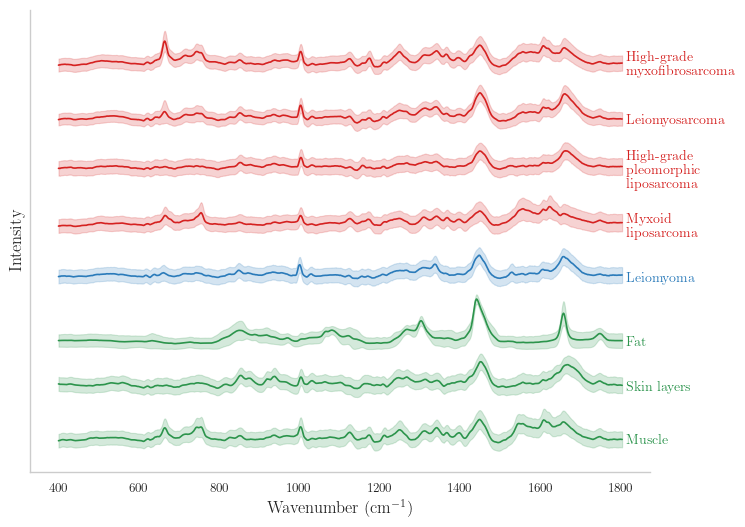

In [25]:
import textwrap

# Define color palettes for different tissue types
color_palettes = {
    'Malignant': sns.color_palette("Reds_r"),
    'Benign': sns.color_palette("Blues_r"),
    'Normal': sns.color_palette("Greens_r"),
    'Intermediate': sns.color_palette("Oranges_r")
}

# Plot the average spectra with std as background
classes = list(spectra_dict.keys())
num_classes = len(classes)
offset = 1  # Offset value to separate plots

fig_avg, ax_avg = plt.subplots()

def remove_borders(ax):
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(True)
  ax.spines['left'].set_visible(True)

# Apply the function to both axes
remove_borders(ax_avg)

counter = counter_m = 0
for i, (key, value) in enumerate(tissue_classification.items()):
    class_name = key
    if class_name not in tissue_types:
        continue
    mean = mean_spectra[class_name]
    std = std_spectra[class_name]
    tissue_type = tissue_classification[class_name]
    tissue_type = metadata['Tissue Classification'][metadata['ID_Type'] == class_name].values[0]
    final_diagnosis = metadata['Final Diagnosis'][metadata['ID_Type'] == class_name].values[0]
    ID_Type = metadata['ID_Type'][metadata['ID_Type'] == class_name].values[0]

    x = np.linspace(400, 1800, 1401)

    ax = ax_avg
    color = color_palettes[tissue_type][1]
    counter += 1 

    i = counter
    ax.plot(x, mean + i * offset, label=final_diagnosis, color=color)
    ax.fill_between(x, mean - std + i * offset, mean + std + i * offset, alpha=0.2, color=color)
    wrapped_text = textwrap.fill(final_diagnosis, width=16)  # Adjust width as needed
    ax.text(1810, np.mean(mean + i * offset) - 0.1, wrapped_text, color=color, va='center', fontsize=10, ha='left')


ax_avg.set_xlabel('Wavenumber (cm$^{-1}$)', fontsize=12)
ax_avg.set_ylabel('Intensity', fontsize=12)
ax_avg.set_yticks([])  # Remove y-axis ticks


du.save_fig(fig=fig_avg, fig_name='average_spectra',
            fig_dir=IMAGES_DIR,
            fig_fmt="pdf",
            fig_size=(8, 6))
plt.show()

## Visualize Average Spectra by Tissue Type

This visualization shows the average Raman spectra for each tissue type, with shaded regions representing the standard deviation. Different tissue types are color-coded (red for malignant, blue for benign, green for normal, orange for intermediate). This helps identify the spectral features that distinguish different tissue types and that the model uses for classification.

The spectra are vertically offset for clarity, and each is labeled with its final diagnosis. The x-axis represents the Raman shift (wavenumber) in cm⁻¹, which corresponds to specific molecular vibrations.

## Conclusion

The evaluation results demonstrate the model's ability to classify different tissue types based on their Raman spectroscopic signatures. The various performance metrics and visualizations provide a comprehensive assessment of the model's strengths and limitations for clinical applications. Particularly important are the sensitivity and specificity for malignant tissue types, as these directly impact the model's potential utility in cancer diagnostics.